In [1]:
## Imports
import time
import webbrowser
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import pickle

import statsmodels.api as sm
import matplotlib

from math import sqrt

import time_series_functions as tsf

import statsmodels.api as sm

import statsmodels

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, r2_score

plt.figure(figsize=(8, 16), dpi=80)

import autoreload
%load_ext autoreload
%autoreload 2

<Figure size 640x1280 with 0 Axes>

In [2]:
##Loading gthe datset and cleaning dups
df=pd.read_csv('AEP_hourly.csv')
#print(df.dtypes,df.shape)
df=df.groupby('Datetime').AEP_MW.mean()
df=df.reset_index()

#creating the time series
df['Datetime']=pd.to_datetime(df['Datetime'])
new_df=df.set_index(['Datetime'])

new_df.sort_index(inplace=True)
##Creating full calendar
start=new_df.index[0]
end=new_df.index[-1]
full_calendar=pd.date_range(start, end,freq='H')
##Putting it all together
calendar=pd.DataFrame(full_calendar,columns=['Datetime']).set_index('Datetime')#,new_df.head()
final_df=calendar.join(new_df)
print(final_df.isnull().sum())
final_df=final_df.interpolate()
final_df.head()
print(final_df.isnull().sum())

monthly_df=final_df[['AEP_MW']].resample('M').sum()[3:-1]
monthly_df.columns=['energy']
monthly_df.head()

AEP_MW    27
dtype: int64
AEP_MW    0
dtype: int64


,energy
Datetime,
2005-01-31,12735114.0
2005-02-28,11085745.0
2005-03-31,11847502.0
2005-04-30,10102660.5
2005-05-31,10181694.0


## Recovering a dataframe where to store results

In [61]:
results=pd.read_csv('scores.csv',index_col=0)
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,1641692.33


# Splitting train and test

<AxesSubplot:title={'center':'Monthly Sales'}, xlabel='Datetime'>

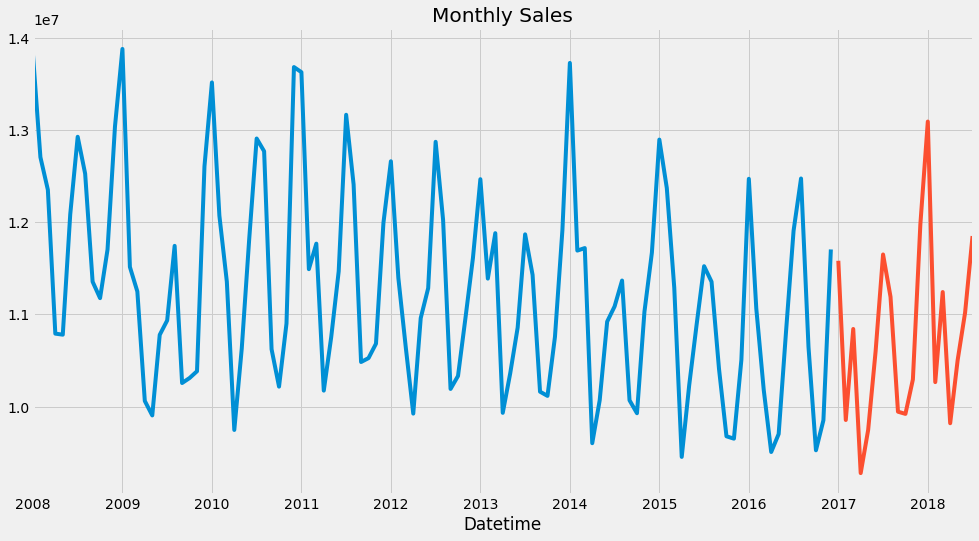

In [62]:
train=monthly_df.loc['2008':'2016'].copy()
test=monthly_df.loc['2017':'2018'].copy()
train.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)
test.energy.plot(figsize=(15,8), title= 'Monthly Sales', fontsize=14)

## 1. Unobserved component model

In [63]:
# smooth trend model without seasonal or cyclical components
model = {
    'level': 'smooth trend', 'cycle': False, 'seasonal': None, 
}
gcag_mod = sm.tsa.UnobservedComponents(monthly_df['energy'], **model)
gcag_res = gcag_mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58900D+01    |proj g|=  6.35935D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.359D-07   1.589D+01
  F =   15.889966357015012     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


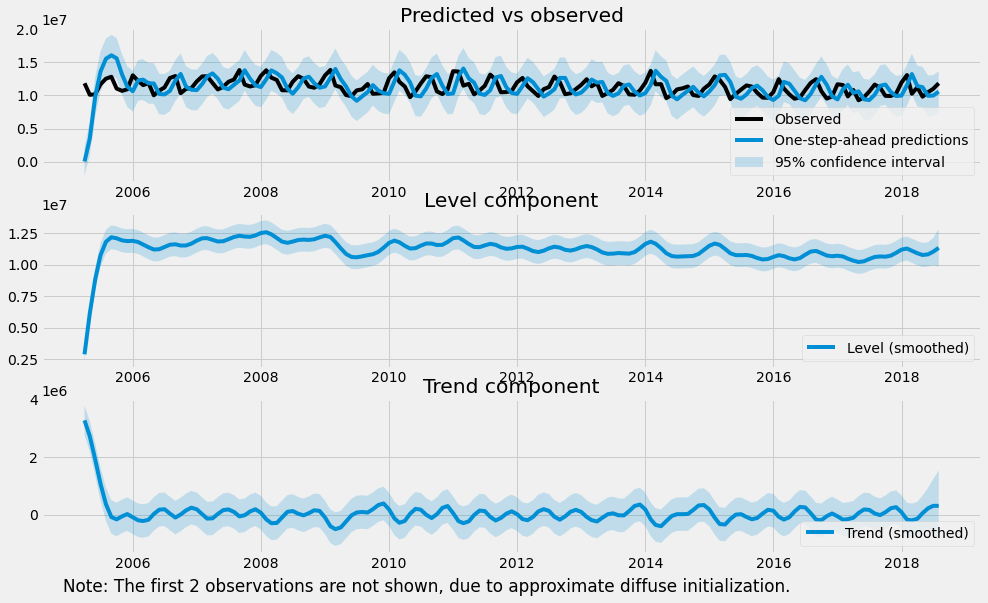

In [30]:
fig = gcag_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [68]:
# Perform rolling prediction and multistep forecast
num_steps = len(test)
predict_res = gcag_res.get_prediction(dynamic=monthly_df['energy'].shape[0]-len(test))

predict = predict_res.predicted_mean
ci = predict_res.conf_int()

In [72]:
rmse=round(np.sqrt(mean_squared_error(test.energy,predict[-len(test):])),2)
results.loc['UCM']=rmse
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,1641692.33
UCM,1733793.21


## 2. Unobserved Component Model with seasonality

In [74]:
seasonal_model = {
    'level': 'local level',
    'seasonal': 12
}
llmod = sm.tsa.UnobservedComponents(monthly_df['energy'], **seasonal_model)
ll_level_res = llmod.fit(method='powell', disp=False)

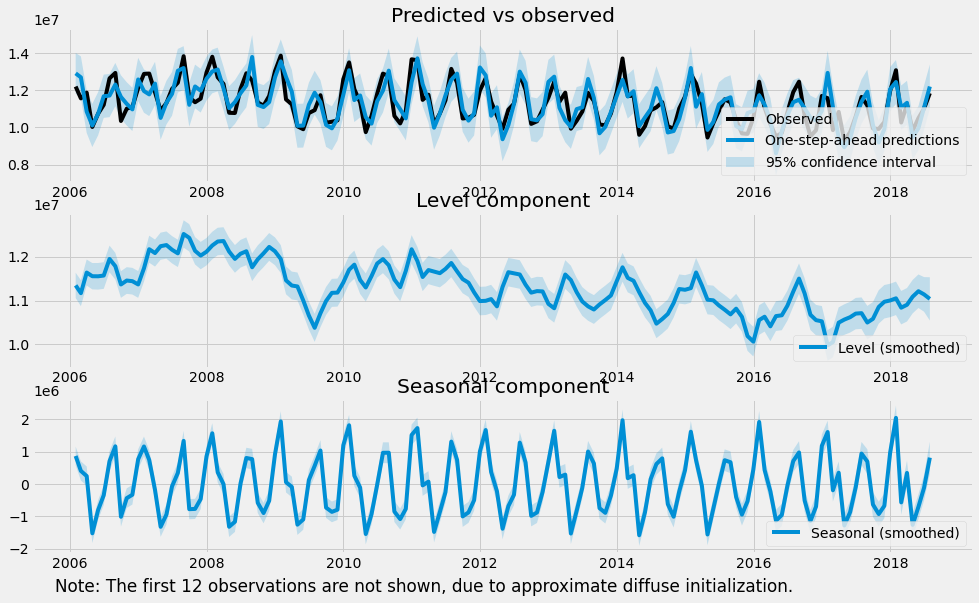

In [76]:
fig = ll_level_res.plot_components(legend_loc='lower right', figsize=(15, 9));

In [77]:
# Perform rolling prediction and multistep forecast
num_steps = len(test)
predict_res2 = ll_level_res.get_prediction(dynamic=monthly_df['energy'].shape[0]-len(test))

predict2 = predict_res2.predicted_mean
ci = predict_res2.conf_int()

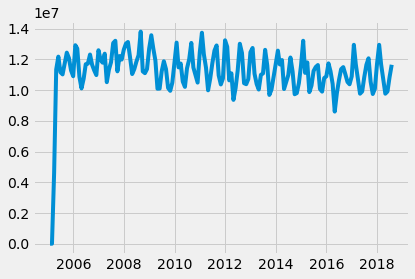

In [78]:
plt.plot(predict2)

In [79]:
rmse=round(np.sqrt(mean_squared_error(test.energy,predict2[-len(test):])),2)
results.loc['SUCM']=rmse
results=results.sort_values('rmse')
results

,rmse
prophet,568170.97
holt_winter,640244.45
SUCM,708550.15
holt_linear,938473.78
moving_average,944047.61
arima,962103.54
SES,974246.68
simple_average,1072483.57
naive,1325608.56
sarima,1641692.33


In [ ]:
rms_ma = round(sqrt(mean_squared_error(test.energy, preds.moving_average)),2)
results.loc['moving_average']=rms_ma
results=results.sort_values('rmse')
results

## 3. Gaussian HMM.

In [ ]:
fit2 = SimpleExpSmoothing(train.energy).fit(smoothing_level=0.6,optimized=False)
preds['SimpleExponentialSmoothing'] = fit2.forecast(len(test))
plt.figure(figsize=(12,8))
plt.plot(train.index, train['energy'], label='Train')
plt.plot(test.index,test['energy'], label='Test')
plt.plot(preds.index,preds['moving_average'], label='SimpleExponentialSmoothing Forecast')
plt.legend(loc='best')
plt.title("SES Forecast");

In [ ]:
rms_ses = round(sqrt(mean_squared_error(test.energy, preds.SimpleExponentialSmoothing)),2)
results.loc['SES']=rms_ses
results=results.sort_values('rmse')
results


## 5. Holt's Linear Trend: We are adding the trend to the SES to make forecasts

In [ ]:
fit1 = Holt(train.energy).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
preds['holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.title("Holt's Linear");
plt.show()

In [ ]:
rms_holt = round(sqrt(mean_squared_error(test.energy, preds.holt_linear)),2)
results.loc['holt_linear']=rms_holt
results=results.sort_values('rmse')
results

## 6. Holt's Winter: Let's add the seasonality to make forecasts

In [ ]:

fit1 = ExponentialSmoothing(train.energy ,seasonal_periods=12 ,trend='add', seasonal='add',).fit()
preds['holt_winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.holt_winter, label='Holt_Winter')
plt.legend(loc='best')
plt.title("Holt's Winter");
plt.show()

In [ ]:
rms_holtwinter = round(sqrt(mean_squared_error(test.energy, preds.holt_winter)),2)
results.loc['holt_winter']=rms_holtwinter
results=results.sort_values('rmse')
results

## 7: ARIMA---AR for AutoRegressive, I for Integrated and MA for moving average

In [ ]:
with open('best_parameters.pkl', 'rb') as f:
    bp=pickle.load(f)
bp['monthly']

In [ ]:
model = ARIMA(train.energy, order=(0, 1, 2))
model_fit = model.fit()
# make prediction
preds['arima'] = model_fit.predict(start = len(train), end =len(train)+len(test), dynamic= True)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.arima, label='Sarima')
plt.legend(loc='best')
plt.show()

In [ ]:
rms_arima = round(sqrt(mean_squared_error(test.energy, preds.arima)),2)
results.loc['arima']=rms_arima
results=results.sort_values('rmse')
results

## 8: SARIMA. Adding seasonality to ARIMA

In [ ]:
#(0, 1, 2), (0, 1, 2, 12)
#(2, 2, 2), (2, 2, 0, 12)
fit1 = sm.tsa.statespace.SARIMAX(train.energy, order=(0, 1, 2),seasonal_order=(0,1,2,12)).fit()
preds['sarima'] = fit1.predict(start = len(train), end =len(train)+len(test), dynamic= True)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.sarima, label='SARIMA')
plt.legend(loc='best')
plt.show()

In [ ]:
rms_sarima = round(sqrt(mean_squared_error(test.energy, preds.sarima)),2)
results.loc['sarima']=rms_sarima
results=results.sort_values('rmse')
results

## 9: Prophet. Asking for help to FaceBook.

In [ ]:
#Prophet

seasonality=12

freq='M'
####Prepping for Prophet
pro_train=train.reset_index()

pro_train.rename(columns={'energy':'y','Datetime':'ds'}, inplace = True)

pro_train['y'] = np.log(pro_train['y'])
model = Prophet()
model.fit(pro_train)
future = model.make_future_dataframe(periods=len(test), freq = 'M')
forecast = model.predict(future)
pro_preds=forecast.set_index('ds').yhat.tail(len(test)).values
preds['fbp_preds']=np.exp(pro_preds)
plt.figure(figsize=(16,8))
plt.plot( train.energy, label='Train')
plt.plot(test.energy, label='Test')
plt.plot(preds.fbp_preds, label='Prophet')
plt.legend(loc='best')
plt.show()

In [ ]:
rms_prophet = round(sqrt(mean_squared_error(test.energy, preds.fbp_preds)),2)
results.loc['prophet']=rms_prophet
results=results.sort_values('rmse')
results